# Transactions Fraud Detection

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Timotej Zatko](https://github.com/timzatko)

## Prototype #1 Grey Wolf Algorithm Application on Decision Tree Classifier

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

from NiaPy.task import StoppingTask, OptimizationType
from NiaPy.algorithms.basic import GreyWolfOptimizer

from src.dataset import load_processed_data
from src.evaluation import custom_classification_report

from src.classification_benchmark import ClassificationBenchmark

### Load the data

In [3]:
%%time

x_train, y_train, _, _ = load_processed_data(frac=0.01)

Number of records:
  x_train - 4724
  y_train - 4724
  x_test - 1181
  y_test - 1181
CPU times: user 34 s, sys: 2.95 s, total: 36.9 s
Wall time: 48.5 s


### Setup classification benchmark

In [4]:
def model_fn():
    return DecisionTreeClassifier(random_state=42)

In [5]:
columns_count = len(x_train.columns)

_x_train, _x_val, _y_train, _y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

benchmark = ClassificationBenchmark(
    model_fn,
    roc_auc_score,
    _x_train,
    _y_train,
    _x_val,
    _y_val
)

### Find optimal features

In [8]:
def optimize(benchmark, nGEN):
    """
    Optimize task with GWO optimizer.
    
    :param benchmark: NiaPy.Benchmark to optimize
    :param nGEN: number of generations
    """
    
    best_columns = None
    best_score = 0
    
    for i in range(5):
        # when using OptimizationType.MAXIMIZATION, the library will fail
        # we use OptimizationType.MINIMIZATION instead and invert the score
        task = StoppingTask(D=benchmark.get_length(), nGEN=nGEN, optType=OptimizationType.MINIMIZATION, benchmark=benchmark)
        algo = GreyWolfOptimizer(NP=25)
        solution_vec, score = algo.run(task=task)    
        
        # invert the score
        score = 1 - score
        columns = benchmark.select_columns(solution_vec)
        
        print(f'Score: {score}')
        print(columns)
        print('\n')
        
        if score > best_score:
            best_score = score
            best_columns = columns

    print('---')
    print(f'Score: {best_score}')
            
    return best_columns

Find the optimal combination of columns.

In [9]:
%%time

columns = optimize(benchmark, 100)

Score: 0.8222982988635561
['TransactionDT', 'C1', 'C3', 'C4', 'C5', 'C7', 'C8', 'C10', 'D3', 'D4', 'D10', 'V4', 'V9', 'V12', 'V14', 'V21', 'V24', 'V37', 'V39', 'V45', 'V50', 'V52', 'V54', 'V55', 'V62', 'V64', 'V66', 'V68', 'V69', 'V71', 'V76', 'V78', 'V79', 'V81', 'V87', 'V90', 'V92', 'V96', 'V97', 'V100', 'V105', 'V108', 'V112', 'V117', 'V118', 'V121', 'V125', 'V133', 'V134', 'V137', 'V281', 'V282', 'V289', 'V291', 'V293', 'V298', 'V299', 'V302', 'V303', 'V304', 'V306', 'V309', 'V311', 'V317', 'ProductCD_C', 'ProductCD_H', 'ProductCD_other', 'card1_other', 'card4_other', 'M1_T', 'M3_other']


Score: 0.8121867720759511
['C1', 'C3', 'C5', 'C7', 'C8', 'C11', 'D4', 'D10', 'V4', 'V8', 'V10', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V20', 'V22', 'V24', 'V31', 'V33', 'V52', 'V53', 'V60', 'V64', 'V65', 'V67', 'V68', 'V70', 'V71', 'V82', 'V85', 'V87', 'V90', 'V93', 'V94', 'V98', 'V100', 'V101', 'V103', 'V104', 'V107', 'V108', 'V109', 'V110', 'V114', 'V120', 'V125', 'V128', 'V129', 'V131', 'V

We found the best solution from 5 independent runs of GWO algorithm. During every run we captured a different solution. For the final submission, we probably would not like to use "the best one", because we would like to have some variance. Maybe we can try to merge these solution together.

### Train only with selected features and evaluate on test data

We will train the model with selected features on the whole dataset.

In [10]:
x_train, y_train, x_test, y_test = load_processed_data()

Number of records:
  x_train - 472432
  y_train - 472432
  x_test - 118108
  y_test - 118108


Train classifier with selected features.

In [12]:
%%time

clf = model_fn()
clf = clf.fit(x_train[columns], y_train)

CPU times: user 14.9 s, sys: 37.5 ms, total: 14.9 s
Wall time: 14.9 s


Evaluate trained model.

not fraud
precision: 0.9774296102436197
recall: 0.9806246971232213
f1-score: 0.9790245468659973
support: 113495


is fraud
precision: 0.4816124469589816
recall: 0.4428788207240408
f1-score: 0.4614342179559571
support: 4613


accuracy: 0.9596217021708945


macro avg
precision: 0.7295210286013006
recall: 0.7117517589236311
f1-score: 0.7202293824109772
support: 118108


weighted avg
precision: 0.958064244864204
recall: 0.9596217021708945
f1-score: 0.9588087766619298
support: 118108


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
micro: 0.7295210286013006
macro: 0.7295210286013006
samples: 0.7295210286013006
weighted: 0.7295210286013006


CPU times: user 670 ms, sys: 8.19 ms, total: 678 ms
Wall time: 684 ms


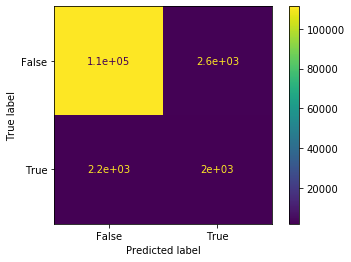

In [13]:
%%time

custom_classification_report(clf, x_test[columns], y_test)